## Dataset Download

In [1]:
!gdown 1doU9FE1tJ-0IL4tKZUOOp76JkXKuTkFU

Downloading...
From (original): https://drive.google.com/uc?id=1doU9FE1tJ-0IL4tKZUOOp76JkXKuTkFU
From (redirected): https://drive.google.com/uc?id=1doU9FE1tJ-0IL4tKZUOOp76JkXKuTkFU&confirm=t&uuid=6ad8c245-9dd7-44b7-879e-53b2c6813d9b
To: /kaggle/working/anxiety_dataset_complete.zip
100%|███████████████████████████████████████| 1.41G/1.41G [00:08<00:00, 170MB/s]


In [2]:
!unzip anxiety_dataset_complete.zip > /dev/null

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import AutoTokenizer, AutoModel, CLIPImageProcessor, CLIPVisionModel
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import json
import math

TRAIN_RATIO = 0.7  # 70% train
VAL_RATIO = 0.1  # 10% validation
TEST_RATIO = 0.2 # 20% test
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
LR = 2e-5
MAX_LEN = 512
FUSION_DIM = 768
LABELS = ["Nervousness", "Lack of Worry Control", "Excessive Worry",
          "Difficulty Relaxing", "Restlessness", "Impending Doom"]
LABEL_MAP = {i: idx for idx, i in enumerate(LABELS)}

## Custom Dataset

In [4]:
class MultimodalAnxietyDataset(Dataset):
    def __init__(self, data, image_path, tokenizer, image_processor, max_len=512):
        self.data = data
        self.tokenizer = tokenizer
        self.image_processor = image_processor
        self.max_len = max_len
        self.img_path = image_path
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]

        ocr_text = sample["ocr_text"]
        figurative_reasoning = sample["figurative_reasoning"]
        combined_text = ocr_text + " [SEP] " + figurative_reasoning

        encoding = self.tokenizer(
            combined_text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt",
        )

        image_path = os.path.join(self.img_path, sample["sample_id"] + ".jpg")
        image = Image.open(image_path).convert("RGB")
        image_tensor = self.image_processor(image, return_tensors="pt")

        label = LABEL_MAP[sample["meme_anxiety_category"]]

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "image": image_tensor,
            "label": torch.tensor(label, dtype=torch.long)
        }

def custom_collate_fn(batch):
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    labels = torch.stack([item['label'] for item in batch])

    images = {}
    for key in batch[0]['image'].keys():
        if isinstance(batch[0]['image'][key], torch.Tensor):
            images[key] = torch.stack([item['image'][key].squeeze(0) for item in batch])

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'image': images,
        'label': labels,
    }

## Model Definition

In [ ]:
class CrossAttentionLayer(nn.Module):
    def __init__(self, hidden_size, num_attention_heads=8, dropout=0.1):
        super().__init__()
        self.num_attention_heads = num_attention_heads
        self.attention_head_size = hidden_size // num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(hidden_size, self.all_head_size)
        self.key = nn.Linear(hidden_size, self.all_head_size)
        self.value = nn.Linear(hidden_size, self.all_head_size)

        self.output = nn.Linear(hidden_size, hidden_size)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_size)

        self.ffn = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size * 4, hidden_size),
            nn.Dropout(dropout)
        )
        self.ffn_layer_norm = nn.LayerNorm(hidden_size)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, x, context):
        mixed_query_layer = self.query(x)
        mixed_key_layer = self.key(context)
        mixed_value_layer = self.value(context)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)

        attention_probs = nn.Softmax(dim=-1)(attention_scores)
        attention_probs = self.dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)

        attention_output = self.output(context_layer)
        attention_output = self.dropout(attention_output)
        attention_output = self.layer_norm(attention_output + x)

        ffn_output = self.ffn(attention_output)

        output = self.ffn_layer_norm(ffn_output + attention_output)

        return output
    
class MultimodalAttentionModel(nn.Module):
    def __init__(self, text_model_name="bert-base-uncased", num_classes=3, fusion_dim=768):
        super(MultimodalAttentionModel, self).__init__()

        self.text_encoder = AutoModel.from_pretrained(text_model_name)
        self.text_dim = self.text_encoder.config.hidden_size

        self.vision_encoder = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32")
        self.vision_dim = self.vision_encoder.config.hidden_size

        self.text_dim = self.text_encoder.config.hidden_size
        self.vision_dim = self.vision_encoder.config.hidden_size
        fusion_dim = 1024
        contrastive_dim = 256

        self.text_projections = nn.ModuleList([
            nn.Linear(self.text_dim, fusion_dim) for _ in range(3)
        ])

        self.vision_projections = nn.ModuleList([
            nn.Linear(self.vision_dim, fusion_dim) for _ in range(3)
        ])

        self.co_attention_layers = nn.ModuleList([
            CrossAttentionLayer(fusion_dim) for _ in range(3)
        ])

        self.expert_nets = nn.ModuleList([
            nn.Sequential(
                nn.Linear(fusion_dim, fusion_dim),
                nn.LayerNorm(fusion_dim),
                nn.GELU(),
                nn.Dropout(0.2)
            ) for _ in range(4)
        ])

        self.moe_gate = nn.Linear(fusion_dim, 4)

        self.classifier = nn.Sequential(
            nn.Linear(fusion_dim, fusion_dim),
            nn.LayerNorm(fusion_dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(fusion_dim, num_classes)
        )

        self.contrastive_projection = nn.Sequential(
            nn.Linear(fusion_dim, fusion_dim // 2),
            nn.LayerNorm(fusion_dim // 2),
            nn.GELU(),
            nn.Linear(fusion_dim // 2, contrastive_dim)
        )

        self.text_contrastive_proj = nn.Sequential(
            nn.Linear(self.text_dim, contrastive_dim),
            nn.LayerNorm(contrastive_dim),
            nn.GELU()
        )

        self.image_contrastive_proj = nn.Sequential(
            nn.Linear(self.vision_dim, contrastive_dim),
            nn.LayerNorm(contrastive_dim),
            nn.GELU()
        )

    def forward(self, input_ids, attention_mask, image_features, get_embeddings=False):
        text_outputs = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        text_features = [
            text_outputs.hidden_states[-i][:, 0] for i in range(1, 4)
        ]
        text_features = [
            proj(feat) for proj, feat in zip(self.text_projections, text_features)
        ]

        text_cls = text_outputs.last_hidden_state[:, 0]

        vision_outputs = self.vision_encoder(**image_features, output_hidden_states=True)
        vision_features = [
            vision_outputs.hidden_states[-i][:, 0] for i in range(1, 4)
        ]
        vision_features = [
            proj(feat) for proj, feat in zip(self.vision_projections, vision_features)
        ]

        image_cls = vision_outputs.pooler_output

        fused_features = []
        for text_feat, vision_feat, co_attn in zip(text_features, vision_features, self.co_attention_layers):
            fused_feat = co_attn(text_feat.unsqueeze(1), vision_feat.unsqueeze(1))
            fused_features.append(fused_feat.squeeze(1))

        combined_feature = sum(fused_features) / len(fused_features)

        expert_outputs = [expert(combined_feature) for expert in self.expert_nets]
        expert_gates = F.softmax(self.moe_gate(combined_feature), dim=1)

        moe_output = torch.zeros_like(expert_outputs[0])
        for i, expert_out in enumerate(expert_outputs):
            moe_output += expert_out * expert_gates[:, i].unsqueeze(1)

        logits = self.classifier(moe_output)

        multimodal_contrastive = self.contrastive_projection(moe_output)
        text_contrastive = self.text_contrastive_proj(text_cls)
        image_contrastive = self.image_contrastive_proj(image_cls)

        multimodal_contrastive = F.normalize(multimodal_contrastive, p=2, dim=1)
        text_contrastive = F.normalize(text_contrastive, p=2, dim=1)
        image_contrastive = F.normalize(image_contrastive, p=2, dim=1)

        if get_embeddings:
            return {
                "logits": logits,
                "multimodal_embedding": multimodal_contrastive,
                "text_embedding": text_contrastive,
                "image_embedding": image_contrastive
            }

        return logits
    
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss(reduction="sum")

    def forward(self, modal1, modal2):
        batch_size = modal1.shape[0]

        features = torch.cat([modal1, modal2], dim=0)
        similarity_matrix = torch.matmul(features, features.T)

        mask = (~torch.eye(2 * batch_size, dtype=bool, device=features.device)).float()

        similarity_matrix = similarity_matrix * mask
        similarity_matrix = similarity_matrix / self.temperature

        labels = torch.arange(batch_size, device=features.device, dtype=torch.long)
        labels = torch.cat([labels + batch_size, labels], dim=0)

        loss = self.criterion(similarity_matrix, labels)
        loss = loss / (2 * batch_size)

        return loss


## Training Functions

In [ ]:
def train_multimodal_model(model, train_data, val_data, img_path, epochs, model_save_name):
    tokenizer = AutoTokenizer.from_pretrained("mental/mental-roberta-base")
    image_processor = CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch32")

    train_dataset = MultimodalAnxietyDataset(train_data, img_path, tokenizer, image_processor, max_len=MAX_LEN)
    val_dataset = MultimodalAnxietyDataset(val_data, img_path, tokenizer, image_processor, max_len=MAX_LEN)

    print("Train Set Size:", len(train_dataset))
    print("Validation Set Size:", len(val_dataset))

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=custom_collate_fn
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=custom_collate_fn
    )

    optimizer = optim.AdamW(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2, verbose=True
    )
    criterion = nn.CrossEntropyLoss()
    contrastive_criterion = ContrastiveLoss(temperature=0.07)
    contrastive_weight = 0.3

    model = model.to(DEVICE)
    model = nn.DataParallel(model)

    best_f1 = 0
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        model.train()
        train_loss = 0
        train_preds, train_labels = [], []

        for batch in tqdm(train_loader, desc="Training"):
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["label"].to(DEVICE)
            image_features = {k: v.to(DEVICE) for k, v in batch["image"].items()}

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask, image_features, get_embeddings=True)
            logits = outputs["logits"]
            classification_loss = criterion(logits, labels)

            multimodal_text_loss = contrastive_criterion(
                outputs["multimodal_embedding"],
                outputs["text_embedding"]
            )

            multimodal_image_loss = contrastive_criterion(
                outputs["multimodal_embedding"],
                outputs["image_embedding"]
            )

            text_image_loss = contrastive_criterion(
                outputs["text_embedding"],
                outputs["image_embedding"]
            )

            contrastive_loss = (multimodal_text_loss + multimodal_image_loss + text_image_loss) / 3
            loss = (1 - contrastive_weight) * classification_loss + contrastive_weight * contrastive_loss

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            train_loss += loss.item()
            predictions = torch.argmax(logits, dim=1).cpu().numpy()
            train_preds.extend(predictions)
            train_labels.extend(labels.cpu().numpy())

        train_loss = train_loss / len(train_loader)
        train_macro_f1 = f1_score(train_labels, train_preds, average="macro")
        train_weighted_f1 = f1_score(train_labels, train_preds, average="weighted")

        print(f"Train Loss: {train_loss:.4f}")
        print(f"Train Macro-F1: {train_macro_f1:.4f}, Weighted-F1: {train_weighted_f1:.4f}")

        val_loss, val_macro_f1, val_weighted_f1 = evaluate_multimodal_model(
            model, val_loader, criterion
        )

        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Macro-F1: {val_macro_f1:.4f}, Weighted-F1: {val_weighted_f1:.4f}")

        scheduler.step(val_macro_f1)

        f1_hm = 2 * val_macro_f1 * val_weighted_f1 / (val_macro_f1 + val_weighted_f1)
        if f1_hm > best_f1:
            best_f1 = f1_hm
            torch.save(model.state_dict(), f"{model_save_name}_anxiety.pth")
            print("Best model saved!")

    return model

def evaluate_multimodal_model(model, loader, criterion):
    model.eval()
    val_loss = 0
    val_preds, val_labels = [], []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["label"].to(DEVICE)
            image_features = {k: v.to(DEVICE) for k, v in batch["image"].items()}

            logits = model(input_ids, attention_mask, image_features)
            loss = criterion(logits, labels)

            val_loss += loss.item()
            predictions = torch.argmax(logits, dim=1).cpu().numpy()
            val_preds.extend(predictions)
            val_labels.extend(labels.cpu().numpy())

    val_loss = val_loss / len(loader)
    val_macro_f1 = f1_score(val_labels, val_preds, average="macro")
    val_weighted_f1 = f1_score(val_labels, val_preds, average="weighted")

    target_names = [k for k, v in sorted(LABEL_MAP.items(), key=lambda x: x[1])]
    report = classification_report(val_labels, val_preds, target_names=target_names)
    print(report)

    return val_loss, val_macro_f1, val_weighted_f1

## Model Training

In [ ]:
full_train_data = json.load(open("anxiety_train_llava_dataset.json", "r"))
test_data = json.load(open("anxiety_test_llava_dataset.json", "r"))

labels = [LABEL_MAP[item["meme_anxiety_category"]] for item in full_train_data]

train_size = math.ceil(len(full_train_data) * TRAIN_RATIO / (TRAIN_RATIO + VAL_RATIO))
train_data, val_data = train_test_split(
    full_train_data, train_size=train_size, stratify=labels, random_state=42
)

def print_class_distribution(dataset, dataset_name):
    label_counts = Counter([LABEL_MAP[item["meme_anxiety_category"]] for item in dataset])
    print(f"Class distribution in {dataset_name} dataset:")
    for label, count in sorted(label_counts.items()):
        print(f"  {LABELS[label]}: {count}")
    print("-----------------------------------")

print_class_distribution(train_data, "Train")
print_class_distribution(val_data, "Validation")
print_class_distribution(test_data, "Test")

img_path = "anxiety_train_image"

tokenizer = AutoTokenizer.from_pretrained("mental/mental-roberta-base")
image_processor = CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch32")

test_dataset = MultimodalAnxietyDataset(test_data, "anxiety_test_image", tokenizer, image_processor, max_len=MAX_LEN)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=custom_collate_fn
)

Class distribution in Train dataset:
  Nervousness: 373
  Lack of Worry Control: 331
  Excessive Worry: 322
  Difficulty Relaxing: 356
  Restlessness: 405
  Impending Doom: 366
-----------------------------------
Class distribution in Validation dataset:
  Nervousness: 53
  Lack of Worry Control: 47
  Excessive Worry: 46
  Difficulty Relaxing: 51
  Restlessness: 58
  Impending Doom: 52
-----------------------------------
Class distribution in Test dataset:
  Nervousness: 106
  Lack of Worry Control: 94
  Excessive Worry: 92
  Difficulty Relaxing: 102
  Restlessness: 116
  Impending Doom: 105
-----------------------------------


tokenizer_config.json:   0%|          | 0.00/327 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

In [ ]:
model = MultimodalAttentionModel(
    text_model_name="mental/mental-roberta-base",
    num_classes=len(LABEL_MAP),
    fusion_dim=FUSION_DIM
)

trained_model = train_multimodal_model(
    model,
    train_data,
    val_data,
    img_path,
    epochs=30,
    model_save_name="multimodal"
)

Some weights of RobertaModel were not initialized from the model checkpoint at mental/mental-roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train Set Size: 2153
Validation Set Size: 307

Epoch 1/30


Training: 100%|██████████| 135/135 [03:26<00:00,  1.53s/it]


Train Loss: 2.2815
Train Macro-F1: 0.2656, Weighted-F1: 0.2681


Evaluating: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]



          Nervousness       0.57      0.58      0.58        53
Lack of Worry Control       0.57      0.36      0.44        47
      Excessive Worry       0.29      0.04      0.08        46
  Difficulty Relaxing       0.93      0.78      0.85        51
         Restlessness       0.34      0.45      0.39        58
       Impending Doom       0.46      0.87      0.60        52

             accuracy                           0.52       307
            macro avg       0.53      0.51      0.49       307
         weighted avg       0.53      0.52      0.50       307

Validation Loss: 1.2276
Validation Macro-F1: 0.4899, Weighted-F1: 0.4959
Best model saved!

Epoch 2/30


Training: 100%|██████████| 135/135 [03:24<00:00,  1.51s/it]


Train Loss: 1.5366
Train Macro-F1: 0.5968, Weighted-F1: 0.5990


Evaluating: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]



          Nervousness       0.62      0.75      0.68        53
Lack of Worry Control       0.60      0.66      0.63        47
      Excessive Worry       0.73      0.35      0.47        46
  Difficulty Relaxing       0.87      0.90      0.88        51
         Restlessness       0.62      0.45      0.52        58
       Impending Doom       0.57      0.81      0.67        52

             accuracy                           0.65       307
            macro avg       0.67      0.65      0.64       307
         weighted avg       0.67      0.65      0.64       307

Validation Loss: 0.9808
Validation Macro-F1: 0.6420, Weighted-F1: 0.6425
Best model saved!

Epoch 3/30


Training: 100%|██████████| 135/135 [03:25<00:00,  1.52s/it]


Train Loss: 1.0268
Train Macro-F1: 0.7582, Weighted-F1: 0.7589


Evaluating: 100%|██████████| 20/20 [00:14<00:00,  1.38it/s]



          Nervousness       0.67      0.70      0.69        53
Lack of Worry Control       0.67      0.64      0.65        47
      Excessive Worry       0.65      0.43      0.52        46
  Difficulty Relaxing       0.91      0.84      0.88        51
         Restlessness       0.50      0.53      0.52        58
       Impending Doom       0.61      0.79      0.69        52

             accuracy                           0.66       307
            macro avg       0.67      0.66      0.66       307
         weighted avg       0.66      0.66      0.66       307

Validation Loss: 0.9977
Validation Macro-F1: 0.6567, Weighted-F1: 0.6561
Best model saved!

Epoch 4/30


Training: 100%|██████████| 135/135 [03:22<00:00,  1.50s/it]


Train Loss: 0.6771
Train Macro-F1: 0.8647, Weighted-F1: 0.8659


Evaluating: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]



          Nervousness       0.57      0.74      0.64        53
Lack of Worry Control       0.76      0.62      0.68        47
      Excessive Worry       0.55      0.35      0.43        46
  Difficulty Relaxing       0.91      0.84      0.88        51
         Restlessness       0.49      0.66      0.56        58
       Impending Doom       0.76      0.67      0.71        52

             accuracy                           0.65       307
            macro avg       0.67      0.65      0.65       307
         weighted avg       0.67      0.65      0.65       307

Validation Loss: 1.1564
Validation Macro-F1: 0.6498, Weighted-F1: 0.6511

Epoch 5/30


Training: 100%|██████████| 135/135 [03:20<00:00,  1.49s/it]


Train Loss: 0.4743
Train Macro-F1: 0.9311, Weighted-F1: 0.9312


Evaluating: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]



          Nervousness       0.59      0.77      0.67        53
Lack of Worry Control       0.78      0.53      0.63        47
      Excessive Worry       0.56      0.41      0.47        46
  Difficulty Relaxing       0.89      0.80      0.85        51
         Restlessness       0.62      0.64      0.63        58
       Impending Doom       0.64      0.81      0.71        52

             accuracy                           0.67       307
            macro avg       0.68      0.66      0.66       307
         weighted avg       0.68      0.67      0.66       307

Validation Loss: 1.2898
Validation Macro-F1: 0.6607, Weighted-F1: 0.6636
Best model saved!

Epoch 6/30


Training: 100%|██████████| 135/135 [03:20<00:00,  1.49s/it]


Train Loss: 0.3430
Train Macro-F1: 0.9532, Weighted-F1: 0.9541


Evaluating: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]



          Nervousness       0.72      0.55      0.62        53
Lack of Worry Control       0.83      0.53      0.65        47
      Excessive Worry       0.58      0.39      0.47        46
  Difficulty Relaxing       0.93      0.78      0.85        51
         Restlessness       0.47      0.76      0.58        58
       Impending Doom       0.58      0.77      0.66        52

             accuracy                           0.64       307
            macro avg       0.69      0.63      0.64       307
         weighted avg       0.68      0.64      0.64       307

Validation Loss: 1.4604
Validation Macro-F1: 0.6386, Weighted-F1: 0.6399

Epoch 7/30


Training: 100%|██████████| 135/135 [03:22<00:00,  1.50s/it]


Train Loss: 0.2492
Train Macro-F1: 0.9808, Weighted-F1: 0.9810


Evaluating: 100%|██████████| 20/20 [00:14<00:00,  1.39it/s]



          Nervousness       0.58      0.72      0.64        53
Lack of Worry Control       0.69      0.66      0.67        47
      Excessive Worry       0.62      0.43      0.51        46
  Difficulty Relaxing       0.90      0.75      0.82        51
         Restlessness       0.50      0.59      0.54        58
       Impending Doom       0.61      0.63      0.62        52

             accuracy                           0.63       307
            macro avg       0.65      0.63      0.63       307
         weighted avg       0.65      0.63      0.63       307

Validation Loss: 1.5139
Validation Macro-F1: 0.6342, Weighted-F1: 0.6334

Epoch 8/30


Training: 100%|██████████| 135/135 [03:20<00:00,  1.49s/it]


Train Loss: 0.2078
Train Macro-F1: 0.9775, Weighted-F1: 0.9777


Evaluating: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]



          Nervousness       0.60      0.77      0.68        53
Lack of Worry Control       0.58      0.70      0.63        47
      Excessive Worry       0.64      0.35      0.45        46
  Difficulty Relaxing       0.91      0.82      0.87        51
         Restlessness       0.57      0.45      0.50        58
       Impending Doom       0.65      0.81      0.72        52

             accuracy                           0.65       307
            macro avg       0.66      0.65      0.64       307
         weighted avg       0.66      0.65      0.64       307

Validation Loss: 1.5927
Validation Macro-F1: 0.6412, Weighted-F1: 0.6416

Epoch 9/30


Training: 100%|██████████| 135/135 [03:20<00:00,  1.49s/it]


Train Loss: 0.1419
Train Macro-F1: 0.9883, Weighted-F1: 0.9884


Evaluating: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]



          Nervousness       0.69      0.70      0.69        53
Lack of Worry Control       0.79      0.64      0.71        47
      Excessive Worry       0.50      0.46      0.48        46
  Difficulty Relaxing       0.86      0.84      0.85        51
         Restlessness       0.51      0.64      0.56        58
       Impending Doom       0.74      0.71      0.73        52

             accuracy                           0.67       307
            macro avg       0.68      0.66      0.67       307
         weighted avg       0.68      0.67      0.67       307

Validation Loss: 1.5045
Validation Macro-F1: 0.6694, Weighted-F1: 0.6700
Best model saved!

Epoch 10/30


Training: 100%|██████████| 135/135 [03:20<00:00,  1.49s/it]


Train Loss: 0.1089
Train Macro-F1: 0.9930, Weighted-F1: 0.9930


Evaluating: 100%|██████████| 20/20 [00:14<00:00,  1.39it/s]



          Nervousness       0.62      0.75      0.68        53
Lack of Worry Control       0.71      0.74      0.73        47
      Excessive Worry       0.61      0.37      0.46        46
  Difficulty Relaxing       0.90      0.84      0.87        51
         Restlessness       0.52      0.66      0.58        58
       Impending Doom       0.75      0.63      0.69        52

             accuracy                           0.67       307
            macro avg       0.68      0.67      0.67       307
         weighted avg       0.68      0.67      0.67       307

Validation Loss: 1.6204
Validation Macro-F1: 0.6672, Weighted-F1: 0.6679

Epoch 11/30


Training: 100%|██████████| 135/135 [03:21<00:00,  1.49s/it]


Train Loss: 0.0943
Train Macro-F1: 0.9939, Weighted-F1: 0.9940


Evaluating: 100%|██████████| 20/20 [00:14<00:00,  1.39it/s]



          Nervousness       0.67      0.75      0.71        53
Lack of Worry Control       0.78      0.62      0.69        47
      Excessive Worry       0.64      0.39      0.49        46
  Difficulty Relaxing       0.91      0.80      0.85        51
         Restlessness       0.53      0.67      0.59        58
       Impending Doom       0.62      0.75      0.68        52

             accuracy                           0.67       307
            macro avg       0.69      0.66      0.67       307
         weighted avg       0.69      0.67      0.67       307

Validation Loss: 1.6448
Validation Macro-F1: 0.6680, Weighted-F1: 0.6692

Epoch 12/30


Training: 100%|██████████| 135/135 [03:20<00:00,  1.49s/it]


Train Loss: 0.0827
Train Macro-F1: 0.9929, Weighted-F1: 0.9930


Evaluating: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]



          Nervousness       0.59      0.77      0.67        53
Lack of Worry Control       0.70      0.66      0.68        47
      Excessive Worry       0.56      0.39      0.46        46
  Difficulty Relaxing       0.92      0.86      0.89        51
         Restlessness       0.54      0.52      0.53        58
       Impending Doom       0.67      0.75      0.71        52

             accuracy                           0.66       307
            macro avg       0.66      0.66      0.66       307
         weighted avg       0.66      0.66      0.66       307

Validation Loss: 1.7024
Validation Macro-F1: 0.6565, Weighted-F1: 0.6567

Epoch 13/30


Training: 100%|██████████| 135/135 [03:20<00:00,  1.49s/it]


Train Loss: 0.0618
Train Macro-F1: 0.9943, Weighted-F1: 0.9944


Evaluating: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]



          Nervousness       0.65      0.70      0.67        53
Lack of Worry Control       0.84      0.57      0.68        47
      Excessive Worry       0.49      0.43      0.46        46
  Difficulty Relaxing       0.91      0.82      0.87        51
         Restlessness       0.46      0.62      0.53        58
       Impending Doom       0.69      0.69      0.69        52

             accuracy                           0.64       307
            macro avg       0.67      0.64      0.65       307
         weighted avg       0.67      0.64      0.65       307

Validation Loss: 1.7039
Validation Macro-F1: 0.6500, Weighted-F1: 0.6501

Epoch 14/30


Training: 100%|██████████| 135/135 [03:20<00:00,  1.48s/it]


Train Loss: 0.0597
Train Macro-F1: 0.9962, Weighted-F1: 0.9963


Evaluating: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]



          Nervousness       0.64      0.74      0.68        53
Lack of Worry Control       0.72      0.60      0.65        47
      Excessive Worry       0.53      0.37      0.44        46
  Difficulty Relaxing       0.88      0.88      0.88        51
         Restlessness       0.52      0.62      0.57        58
       Impending Doom       0.67      0.71      0.69        52

             accuracy                           0.66       307
            macro avg       0.66      0.65      0.65       307
         weighted avg       0.66      0.66      0.65       307

Validation Loss: 1.6884
Validation Macro-F1: 0.6520, Weighted-F1: 0.6540

Epoch 15/30


Training: 100%|██████████| 135/135 [03:23<00:00,  1.51s/it]


Train Loss: 0.0525
Train Macro-F1: 0.9972, Weighted-F1: 0.9972


Evaluating: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]



          Nervousness       0.64      0.74      0.68        53
Lack of Worry Control       0.71      0.68      0.70        47
      Excessive Worry       0.53      0.39      0.45        46
  Difficulty Relaxing       0.88      0.90      0.89        51
         Restlessness       0.52      0.60      0.56        58
       Impending Doom       0.73      0.67      0.70        52

             accuracy                           0.67       307
            macro avg       0.67      0.66      0.66       307
         weighted avg       0.67      0.67      0.66       307

Validation Loss: 1.7038
Validation Macro-F1: 0.6638, Weighted-F1: 0.6648

Epoch 16/30


Training: 100%|██████████| 135/135 [03:24<00:00,  1.51s/it]


Train Loss: 0.0465
Train Macro-F1: 0.9957, Weighted-F1: 0.9958


Evaluating: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]



          Nervousness       0.64      0.72      0.68        53
Lack of Worry Control       0.71      0.62      0.66        47
      Excessive Worry       0.51      0.39      0.44        46
  Difficulty Relaxing       0.89      0.80      0.85        51
         Restlessness       0.53      0.62      0.57        58
       Impending Doom       0.66      0.73      0.69        52

             accuracy                           0.65       307
            macro avg       0.66      0.65      0.65       307
         weighted avg       0.66      0.65      0.65       307

Validation Loss: 1.7715
Validation Macro-F1: 0.6483, Weighted-F1: 0.6501

Epoch 17/30


Training: 100%|██████████| 135/135 [03:23<00:00,  1.51s/it]


Train Loss: 0.0451
Train Macro-F1: 0.9962, Weighted-F1: 0.9963


Evaluating: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]



          Nervousness       0.65      0.77      0.71        53
Lack of Worry Control       0.69      0.62      0.65        47
      Excessive Worry       0.56      0.39      0.46        46
  Difficulty Relaxing       0.90      0.84      0.87        51
         Restlessness       0.53      0.59      0.56        58
       Impending Doom       0.66      0.73      0.69        52

             accuracy                           0.66       307
            macro avg       0.66      0.66      0.66       307
         weighted avg       0.66      0.66      0.66       307

Validation Loss: 1.7647
Validation Macro-F1: 0.6562, Weighted-F1: 0.6576

Epoch 18/30


Training: 100%|██████████| 135/135 [03:27<00:00,  1.54s/it]


Train Loss: 0.0384
Train Macro-F1: 0.9967, Weighted-F1: 0.9967


Evaluating: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]



          Nervousness       0.65      0.77      0.71        53
Lack of Worry Control       0.72      0.66      0.69        47
      Excessive Worry       0.50      0.39      0.44        46
  Difficulty Relaxing       0.88      0.86      0.87        51
         Restlessness       0.53      0.57      0.55        58
       Impending Doom       0.70      0.71      0.70        52

             accuracy                           0.66       307
            macro avg       0.66      0.66      0.66       307
         weighted avg       0.66      0.66      0.66       307

Validation Loss: 1.7292
Validation Macro-F1: 0.6601, Weighted-F1: 0.6613

Epoch 19/30


Training: 100%|██████████| 135/135 [03:21<00:00,  1.49s/it]


Train Loss: 0.0362
Train Macro-F1: 0.9967, Weighted-F1: 0.9967


Evaluating: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]



          Nervousness       0.65      0.77      0.71        53
Lack of Worry Control       0.71      0.68      0.70        47
      Excessive Worry       0.53      0.39      0.45        46
  Difficulty Relaxing       0.91      0.84      0.88        51
         Restlessness       0.53      0.59      0.56        58
       Impending Doom       0.72      0.75      0.74        52

             accuracy                           0.67       307
            macro avg       0.68      0.67      0.67       307
         weighted avg       0.68      0.67      0.67       307

Validation Loss: 1.7747
Validation Macro-F1: 0.6706, Weighted-F1: 0.6717
Best model saved!

Epoch 20/30


Training: 100%|██████████| 135/135 [03:20<00:00,  1.48s/it]


Train Loss: 0.0353
Train Macro-F1: 0.9958, Weighted-F1: 0.9958


Evaluating: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]



          Nervousness       0.64      0.74      0.68        53
Lack of Worry Control       0.70      0.64      0.67        47
      Excessive Worry       0.53      0.39      0.45        46
  Difficulty Relaxing       0.90      0.86      0.88        51
         Restlessness       0.52      0.59      0.55        58
       Impending Doom       0.69      0.73      0.71        52

             accuracy                           0.66       307
            macro avg       0.66      0.66      0.66       307
         weighted avg       0.66      0.66      0.66       307

Validation Loss: 1.7588
Validation Macro-F1: 0.6573, Weighted-F1: 0.6586

Epoch 21/30


Training: 100%|██████████| 135/135 [03:21<00:00,  1.49s/it]


Train Loss: 0.0361
Train Macro-F1: 0.9972, Weighted-F1: 0.9972


Evaluating: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]



          Nervousness       0.65      0.77      0.71        53
Lack of Worry Control       0.70      0.66      0.68        47
      Excessive Worry       0.55      0.39      0.46        46
  Difficulty Relaxing       0.90      0.86      0.88        51
         Restlessness       0.53      0.59      0.56        58
       Impending Doom       0.70      0.73      0.72        52

             accuracy                           0.67       307
            macro avg       0.67      0.67      0.67       307
         weighted avg       0.67      0.67      0.67       307

Validation Loss: 1.7746
Validation Macro-F1: 0.6664, Weighted-F1: 0.6676

Epoch 22/30


Training: 100%|██████████| 135/135 [03:20<00:00,  1.49s/it]


Train Loss: 0.0343
Train Macro-F1: 0.9971, Weighted-F1: 0.9972


Evaluating: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]



          Nervousness       0.65      0.77      0.71        53
Lack of Worry Control       0.69      0.62      0.65        47
      Excessive Worry       0.56      0.39      0.46        46
  Difficulty Relaxing       0.90      0.88      0.89        51
         Restlessness       0.54      0.59      0.56        58
       Impending Doom       0.67      0.73      0.70        52

             accuracy                           0.67       307
            macro avg       0.67      0.66      0.66       307
         weighted avg       0.67      0.67      0.66       307

Validation Loss: 1.7783
Validation Macro-F1: 0.6617, Weighted-F1: 0.6633

Epoch 23/30


Training: 100%|██████████| 135/135 [03:20<00:00,  1.48s/it]


Train Loss: 0.0350
Train Macro-F1: 0.9967, Weighted-F1: 0.9967


Evaluating: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]



          Nervousness       0.65      0.75      0.70        53
Lack of Worry Control       0.69      0.62      0.65        47
      Excessive Worry       0.56      0.39      0.46        46
  Difficulty Relaxing       0.90      0.88      0.89        51
         Restlessness       0.53      0.59      0.56        58
       Impending Doom       0.67      0.73      0.70        52

             accuracy                           0.66       307
            macro avg       0.67      0.66      0.66       307
         weighted avg       0.66      0.66      0.66       307

Validation Loss: 1.7565
Validation Macro-F1: 0.6591, Weighted-F1: 0.6605

Epoch 24/30


Training: 100%|██████████| 135/135 [03:20<00:00,  1.49s/it]


Train Loss: 0.0342
Train Macro-F1: 0.9976, Weighted-F1: 0.9977


Evaluating: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]



          Nervousness       0.65      0.75      0.70        53
Lack of Worry Control       0.69      0.62      0.65        47
      Excessive Worry       0.56      0.39      0.46        46
  Difficulty Relaxing       0.90      0.88      0.89        51
         Restlessness       0.52      0.59      0.55        58
       Impending Doom       0.68      0.73      0.70        52

             accuracy                           0.66       307
            macro avg       0.67      0.66      0.66       307
         weighted avg       0.66      0.66      0.66       307

Validation Loss: 1.7758
Validation Macro-F1: 0.6594, Weighted-F1: 0.6607

Epoch 25/30


Training: 100%|██████████| 135/135 [03:20<00:00,  1.48s/it]


Train Loss: 0.0327
Train Macro-F1: 0.9971, Weighted-F1: 0.9972


Evaluating: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]



          Nervousness       0.65      0.75      0.70        53
Lack of Worry Control       0.68      0.64      0.66        47
      Excessive Worry       0.55      0.37      0.44        46
  Difficulty Relaxing       0.90      0.88      0.89        51
         Restlessness       0.52      0.59      0.55        58
       Impending Doom       0.69      0.73      0.71        52

             accuracy                           0.66       307
            macro avg       0.66      0.66      0.66       307
         weighted avg       0.66      0.66      0.66       307

Validation Loss: 1.7704
Validation Macro-F1: 0.6585, Weighted-F1: 0.6600

Epoch 26/30


Training: 100%|██████████| 135/135 [03:20<00:00,  1.49s/it]


Train Loss: 0.0330
Train Macro-F1: 0.9966, Weighted-F1: 0.9967


Evaluating: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]



          Nervousness       0.65      0.75      0.70        53
Lack of Worry Control       0.70      0.64      0.67        47
      Excessive Worry       0.56      0.39      0.46        46
  Difficulty Relaxing       0.90      0.88      0.89        51
         Restlessness       0.52      0.59      0.55        58
       Impending Doom       0.69      0.73      0.71        52

             accuracy                           0.67       307
            macro avg       0.67      0.66      0.66       307
         weighted avg       0.67      0.67      0.66       307

Validation Loss: 1.7688
Validation Macro-F1: 0.6630, Weighted-F1: 0.6641

Epoch 27/30


Training: 100%|██████████| 135/135 [03:20<00:00,  1.48s/it]


Train Loss: 0.0315
Train Macro-F1: 0.9976, Weighted-F1: 0.9977


Evaluating: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]



          Nervousness       0.65      0.75      0.70        53
Lack of Worry Control       0.70      0.66      0.68        47
      Excessive Worry       0.56      0.39      0.46        46
  Difficulty Relaxing       0.90      0.88      0.89        51
         Restlessness       0.52      0.59      0.55        58
       Impending Doom       0.70      0.73      0.72        52

             accuracy                           0.67       307
            macro avg       0.67      0.67      0.67       307
         weighted avg       0.67      0.67      0.67       307

Validation Loss: 1.7705
Validation Macro-F1: 0.6666, Weighted-F1: 0.6675

Epoch 28/30


Training: 100%|██████████| 135/135 [03:20<00:00,  1.49s/it]


Train Loss: 0.0329
Train Macro-F1: 0.9976, Weighted-F1: 0.9977


Evaluating: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]



          Nervousness       0.65      0.75      0.70        53
Lack of Worry Control       0.70      0.66      0.68        47
      Excessive Worry       0.56      0.39      0.46        46
  Difficulty Relaxing       0.90      0.88      0.89        51
         Restlessness       0.52      0.59      0.55        58
       Impending Doom       0.70      0.73      0.72        52

             accuracy                           0.67       307
            macro avg       0.67      0.67      0.67       307
         weighted avg       0.67      0.67      0.67       307

Validation Loss: 1.7717
Validation Macro-F1: 0.6666, Weighted-F1: 0.6675

Epoch 29/30


Training: 100%|██████████| 135/135 [03:20<00:00,  1.48s/it]


Train Loss: 0.0317
Train Macro-F1: 0.9991, Weighted-F1: 0.9991


Evaluating: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]



          Nervousness       0.65      0.75      0.70        53
Lack of Worry Control       0.70      0.66      0.68        47
      Excessive Worry       0.56      0.39      0.46        46
  Difficulty Relaxing       0.88      0.88      0.88        51
         Restlessness       0.52      0.59      0.55        58
       Impending Doom       0.70      0.71      0.70        52

             accuracy                           0.67       307
            macro avg       0.67      0.66      0.66       307
         weighted avg       0.67      0.67      0.66       307

Validation Loss: 1.7668
Validation Macro-F1: 0.6631, Weighted-F1: 0.6640

Epoch 30/30


Training: 100%|██████████| 135/135 [03:23<00:00,  1.51s/it]


Train Loss: 0.0313
Train Macro-F1: 0.9972, Weighted-F1: 0.9972


Evaluating: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]



          Nervousness       0.65      0.75      0.70        53
Lack of Worry Control       0.70      0.64      0.67        47
      Excessive Worry       0.56      0.39      0.46        46
  Difficulty Relaxing       0.88      0.88      0.88        51
         Restlessness       0.52      0.59      0.55        58
       Impending Doom       0.69      0.71      0.70        52

             accuracy                           0.66       307
            macro avg       0.67      0.66      0.66       307
         weighted avg       0.66      0.66      0.66       307

Validation Loss: 1.7702
Validation Macro-F1: 0.6595, Weighted-F1: 0.6606


## Inference

In [9]:
!gdown 16mIkJvgao_jahdWoyE-FD5NDste2pY34

Downloading...
From (original): https://drive.google.com/uc?id=16mIkJvgao_jahdWoyE-FD5NDste2pY34
From (redirected): https://drive.google.com/uc?id=16mIkJvgao_jahdWoyE-FD5NDste2pY34&confirm=t&uuid=0c51e6df-b67e-45fd-b75e-dbbbe638c6fd
To: /kaggle/working/multimodal_anxiety.pth
100%|██████████████████████████████████████| 1.04G/1.04G [00:19<00:00, 53.8MB/s]


In [10]:
def inference(test_data, model_path):
    model = MultimodalAttentionModel(
        text_model_name="mental/mental-roberta-base",
        num_classes=len(LABEL_MAP),
        fusion_dim=FUSION_DIM
    )

    model = model.to(DEVICE)

    weights = torch.load(model_path, map_location=DEVICE, weights_only=True)
    weights_single = {k.replace("module.", ""): v for k, v in weights.items()}

    model.load_state_dict(weights_single)
    tokenizer = AutoTokenizer.from_pretrained("mental/mental-roberta-base")
    image_processor = CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch32")

    test_dataset = MultimodalAnxietyDataset(test_data, "anxiety_test_image", tokenizer, image_processor, max_len=MAX_LEN)
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=custom_collate_fn
    )

    loss, macro_f1, weighted_f1 = evaluate_multimodal_model(
        model, test_loader, nn.CrossEntropyLoss()
    )

    print(f"Test Loss: {loss:.4f}")
    print(f"Test Macro-F1: {macro_f1:.4f}, Weighted-F1: {weighted_f1:.4f}")

    return macro_f1, weighted_f1

In [13]:
inference(test_data, "multimodal_anxiety.pth")

Some weights of RobertaModel were not initialized from the model checkpoint at mental/mental-roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 39/39 [00:33<00:00,  1.15it/s]

                       precision    recall  f1-score   support

          Nervousness       0.69      0.75      0.72       106
Lack of Worry Control       0.76      0.66      0.70        94
      Excessive Worry       0.67      0.58      0.62        92
  Difficulty Relaxing       0.75      0.77      0.76       102
         Restlessness       0.57      0.69      0.62       116
       Impending Doom       0.72      0.65      0.68       105

             accuracy                           0.68       615
            macro avg       0.69      0.68      0.69       615
         weighted avg       0.69      0.68      0.68       615

Test Loss: 2.2461
Test Macro-F1: 0.6851, Weighted-F1: 0.6848


(0.6851071306175776, 0.6847534120670663)

## Error Analysis

In [ ]:
def evaluate_multimodal_misclassified(model, loader, criterion, data, num_misclassified=3):
    model.eval()
    val_loss = 0
    val_preds, val_labels = [], []
    
    misclassified_examples = {}
    
    with torch.no_grad():
        batch_idx = 0
        for batch in tqdm(loader, desc="Evaluating"):
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["label"].to(DEVICE)
            image_features = batch["image"]
            
            for k, v in image_features.items():
                image_features[k] = v.to(DEVICE)
            
            logits = model(input_ids, attention_mask, image_features)
            loss = criterion(logits, labels)
            
            val_loss += loss.item()
            predictions = torch.argmax(logits, dim=1).cpu().numpy()
            
            val_preds.extend(predictions)
            val_labels.extend(labels.cpu().numpy())
            
            for i, (pred, label) in enumerate(zip(predictions, labels.cpu().numpy())):
                if pred != label:
                    global_idx = batch_idx * loader.batch_size + i
                    if global_idx < len(data):
                        sample = data[global_idx]
                        ocr_text = sample.get("ocr_text", "")
                        figurative_reasoning = sample.get("figurative_reasoning", "")
                        sample_id = sample.get("sample_id", f"unknown_{global_idx}")
                    else:
                        ocr_text = ""
                        figurative_reasoning = ""
                        sample_id = f"unknown_{global_idx}"
                    
                    orig_img = image_features.get('pixel_values')[i].cpu()
                    
                    misclass_sample = {
                        'pred': int(pred),
                        'label': int(label),
                        'confidence': torch.softmax(logits[i], dim=0)[pred].item(),
                        'image': orig_img,
                        'ocr_text': ocr_text,
                        'figurative_reasoning': figurative_reasoning,
                        'sample_id': sample_id
                    }
                    
                    if label not in misclassified_examples:
                        misclassified_examples[label] = []
                    
                    misclassified_examples[label].append(misclass_sample)
            
            batch_idx += 1
    
    val_loss = val_loss / len(loader)
    val_macro_f1 = f1_score(val_labels, val_preds, average="macro")
    val_weighted_f1 = f1_score(val_labels, val_preds, average="weighted")
    
    target_names = [k for k, v in sorted(LABEL_MAP.items(), key=lambda x: x[1])]
    report = classification_report(val_labels, val_preds, target_names=target_names)
    print(report)
    
    representative_examples = {}
    for label, examples in misclassified_examples.items():
        sorted_examples = sorted(examples, key=lambda x: x['confidence'], reverse=True)
        representative_examples[label] = sorted_examples[:num_misclassified]
    
    return val_loss, val_macro_f1, val_weighted_f1, representative_examples

def display_misclassified_examples(misclassified_examples, label_map=None):
    reverse_label_map = {v: k for k, v in label_map.items()} if label_map else None
 
    for label, examples in misclassified_examples.items():
        class_name = reverse_label_map[label] if reverse_label_map else f"Class {label}"
        print(f"\n--- Misclassified examples for {class_name} (actual class) ---")
        
        for i, example in enumerate(examples):
            pred_class = reverse_label_map[example['pred']] if reverse_label_map else f"Class {example['pred']}"
            true_class = reverse_label_map[example['label']] if reverse_label_map else f"Class {example['label']}"
            
            print(f"\nExample {i+1} (ID: {example['sample_id']}):")
            print(f"  Predicted: {pred_class} (confidence: {example['confidence']:.4f})")
            print(f"  Actual: {true_class}")
            print(f"  OCR Text: {example['ocr_text']}")
            print(f"  Figurative Reasoning: {example['figurative_reasoning']}")
            
            if example['image'] is not None:
                img = example['image']
                if isinstance(img, torch.Tensor):
                    if img.dim() == 3 and img.shape[0] == 3:
                        img = img.permute(1, 2, 0)
                    
                    # reverse transform from clip processor
                    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 1, 3)
                    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 1, 3)
                    img = img * std + mean
                    
                    img = img.numpy()
                    img = np.clip(img, 0, 1)
                
                fig, ax = plt.subplots(figsize=(8, 8))
                ax.imshow(img)
                
                title = f"Predicted: {pred_class} | Actual: {true_class}"
                ax.set_title(title, fontsize=12, fontweight='bold')
                
                plt.axis('off')
                plt.tight_layout()
                plt.show()

In [ ]:
def inference_misclassified(test_data, model_path):
    model = MultimodalAttentionModel(
        text_model_name="mental/mental-roberta-base",
        num_classes=len(LABEL_MAP),
        fusion_dim=FUSION_DIM
    )

    model = model.to(DEVICE)

    weights = torch.load(model_path, map_location=DEVICE, weights_only=True)
    weights_single = {k.replace("module.", ""): v for k, v in weights.items()}

    model.load_state_dict(weights_single)
    tokenizer = AutoTokenizer.from_pretrained("mental/mental-roberta-base")
    image_processor = CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch32")

    test_dataset = MultimodalAnxietyDataset(test_data, "anxiety_test_image", tokenizer, image_processor, max_len=MAX_LEN)
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=custom_collate_fn
    )

    loss, macro_f1, weighted_f1, samples = evaluate_multimodal_misclassified(
        model, test_loader, nn.CrossEntropyLoss(), test_data
    )

    display_misclassified_examples(samples, LABEL_MAP)

    print(f"Test Loss: {loss:.4f}")
    print(f"Test Macro-F1: {macro_f1:.4f}, Weighted-F1: {weighted_f1:.4f}")

    return macro_f1, weighted_f1

Evaluating: 100%|██████████| 39/39 [00:36<00:00,  1.06it/s]

                       precision    recall  f1-score   support

          Nervousness       0.69      0.75      0.72       106
Lack of Worry Control       0.76      0.66      0.70        94
      Excessive Worry       0.67      0.58      0.62        92
  Difficulty Relaxing       0.75      0.77      0.76       102
         Restlessness       0.57      0.69      0.62       116
       Impending Doom       0.72      0.65      0.68       105

             accuracy                           0.68       615
            macro avg       0.69      0.68      0.69       615
         weighted avg       0.69      0.68      0.68       615


--- Misclassified examples for Impending Doom (actual class) ---

Example 1 (ID: TE-205):
  Predicted: Lack of Worry Control (confidence: 1.0000)
  Actual: Impending Doom
  OCR Text: anxiety: something bad is about to happen me: what do you mean anxiety: Citytv
  Figurative Reasoning: 1. Cause-Effect: The meme is about anxiety and the feeling of being overwhelmed.

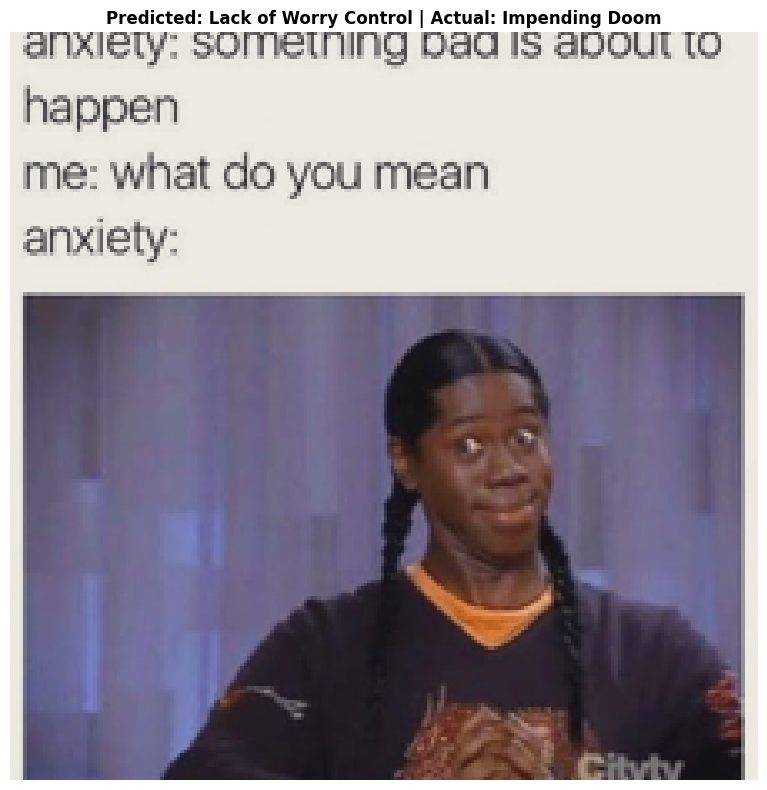


Example 2 (ID: TE-214):
  Predicted: Restlessness (confidence: 1.0000)
  Actual: Impending Doom
  OCR Text: "Are you okay? you've been acting really off lately." me, who hasn't noticed a single behaviour change in myself at all now feeling like something bad is going to happen:
  Figurative Reasoning: 1. Cause-Effect: The meme shows a penguin with a sad face and the words "Are you okay? You've been acting really off-late." This suggests that the penguin might be experiencing depression or feeling overwhelmed. 2. Figurative Understanding: The penguin in the meme represents a common symbol of vulnerability and innocence. The sad face and the phrase "off-late" imply that the penguin is struggling to cope with its emotions or circumstances. 3. Mental State: The penguin in the meme appears to be experiencing sadness, loneliness, or a sense of being overwhelmed. The image may also evoke feelings of empathy or concern for the penguin's well-being.


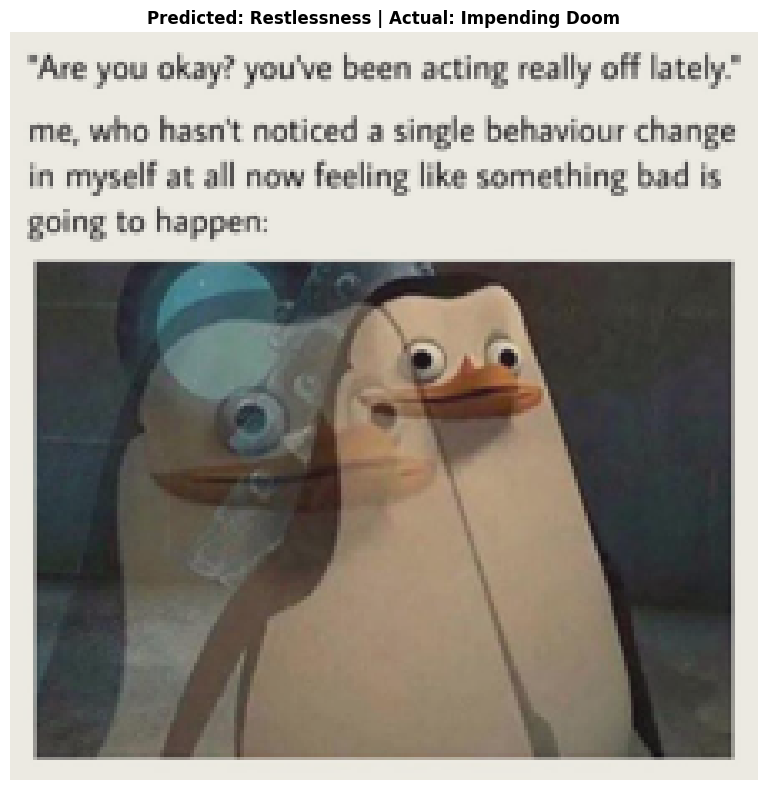


Example 3 (ID: TE-610):
  Predicted: Difficulty Relaxing (confidence: 1.0000)
  Actual: Impending Doom
  OCR Text: How I sleep at night knowing I'm irreparably damaged and will most likely die alone due to my inability to accept love or act right
  Figurative Reasoning: 1. Cause-Effect: The meme shows a cartoon character, likely Homer Simpson, sleeping in bed with a caption stating "How I sleep at night knowing I'm probably going to die alone." The cause of this situation is the character's lack of social connections, which leads to the effect of loneliness and potential isolation. 2. Figurative Understanding: The meme uses a humorous and ironic approach to convey the deeper message of the consequences of loneliness. The cartoon character's sleeping position and the caption's wording create a sense of vulnerability and helplessness, which is a metaphor for the emotional state of loneliness. 3. Mental State: The meme portrays the character as experiencing a state of loneliness and vuln

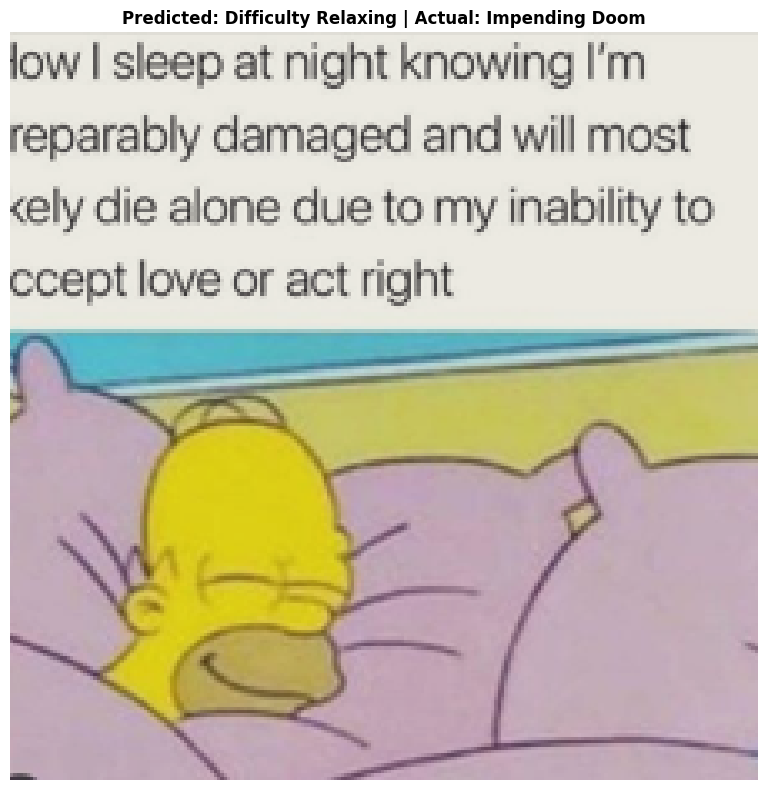


--- Misclassified examples for Lack of Worry Control (actual class) ---

Example 1 (ID: TE-573):
  Predicted: Impending Doom (confidence: 1.0000)
  Actual: Lack of Worry Control
  OCR Text: A situation about to go from bad to worse Me not helping at all
  Figurative Reasoning: 1. Cause-Effect: The fire in the image is a result of a man's actions, specifically, he is trying to burn a chair. This could be an attempt to get rid of the chair or to create a distraction. 2. Figurative Understanding: The image can be interpreted as a metaphor for dealing with difficult situations or overcoming challenges. The man is trying to burn the chair, which might symbolize facing a problem or dealing with a challenging situation. 3. Mental State: The man appears to be in a state of distress or frustration, as he is trying to burn the chair, which could be an attempt to cope with a difficult situation or to escape from it.


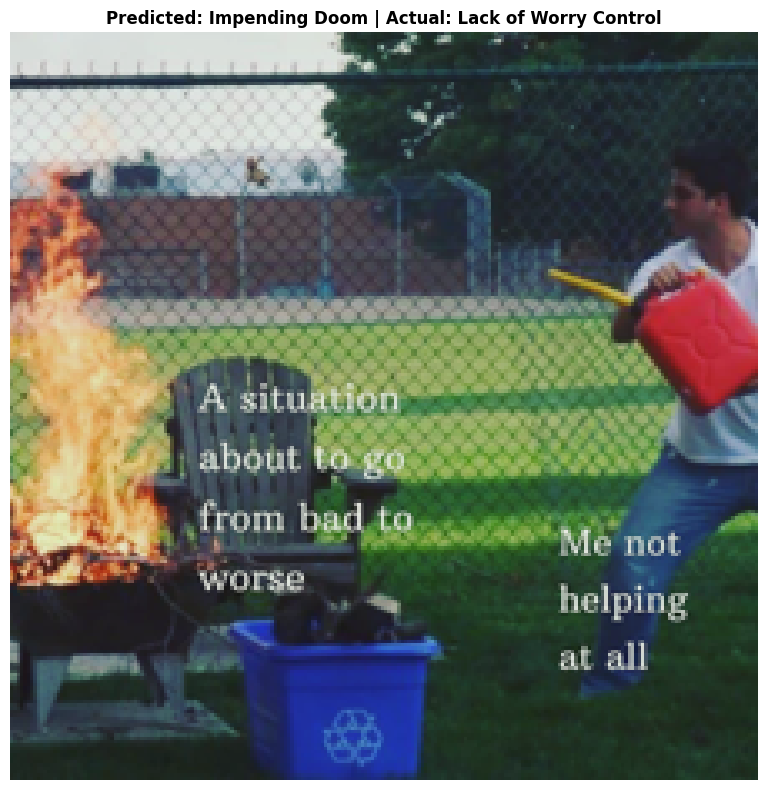


Example 2 (ID: TE-550):
  Predicted: Nervousness (confidence: 1.0000)
  Actual: Lack of Worry Control
  OCR Text: when you are trying to explain something and start to wonder if you know what the fuck you are talking about 19
  Figurative Reasoning: 1. Cause-Effect: The meme shows a character from a cartoon, specifically Spongebob, with a sad expression on his face. The cause of his sadness could be related to the character's experiences in the cartoon, such as facing challenges, dealing with personal issues, or going through a difficult situation. 2. Figurative Understanding: The meme might be interpreted as a representation of the character's emotional state, which could be related to the character's mental or emotional struggles. The sad expression on Spongebob's face might symbolize feelings of loneliness, vulnerability, or even a sense of being overwhelmed by life's challenges. 3. Mental State: The meme portrays Spongebob as feeling sad or depressed. This emotional state could be

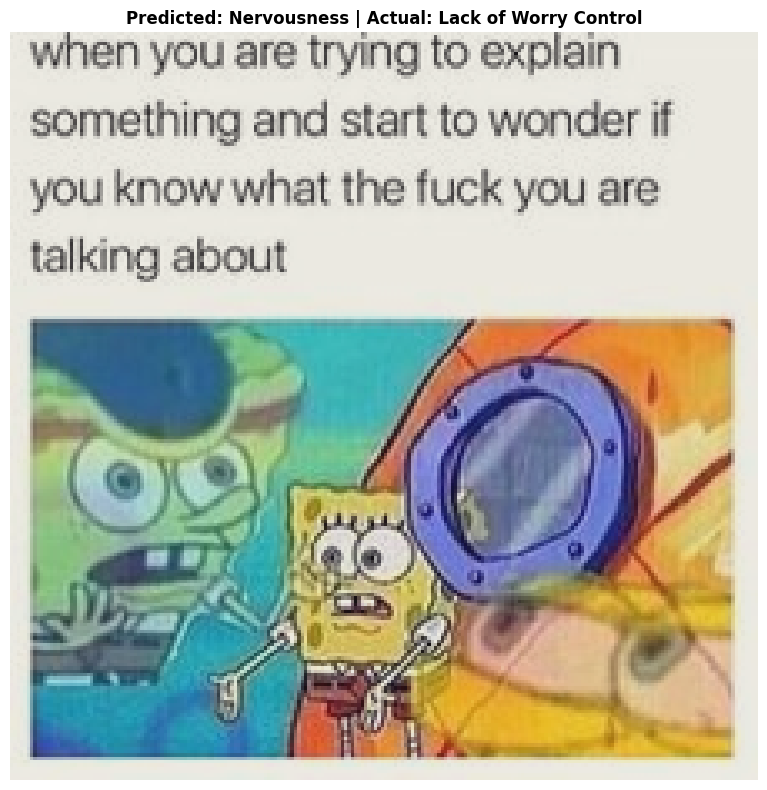


Example 3 (ID: TE-94):
  Predicted: Difficulty Relaxing (confidence: 1.0000)
  Actual: Lack of Worry Control
  OCR Text: Alex @trapppo me hurting my own feelings by creating fake scenarios in my head
  Figurative Reasoning: 1. Cause-Effect: The meme shows a woman lying in bed, with a caption stating that she is "creating fake scenarios in my head." This suggests that she might be experiencing stress, anxiety, or negative thoughts, which could be a result of various factors such as work, relationships, or personal issues. 2. Figurative Understanding: The meme can be interpreted as a metaphor for the human tendency to create stories or scenarios in our minds, often as a coping mechanism for dealing with stress or difficult situations. It can also be seen as a humorous commentary on the common practice of daydreaming or "people-watching" in everyday life. 3. Mental State: The meme depicts a woman in a state of mental distress, as she is described as "hurting" and "creating fake scenarios

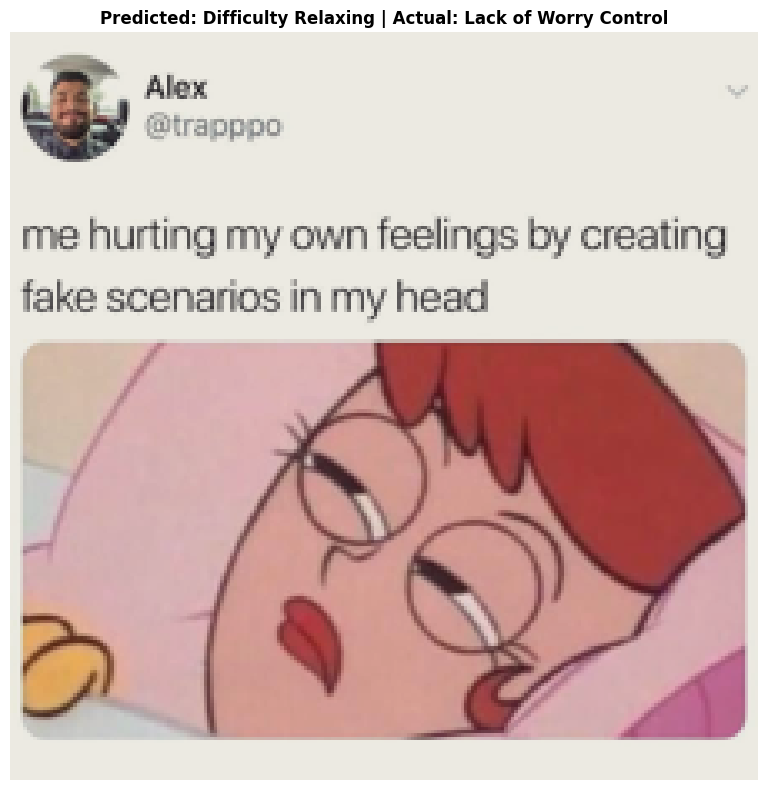


--- Misclassified examples for Restlessness (actual class) ---

Example 1 (ID: TE-565):
  Predicted: Difficulty Relaxing (confidence: 1.0000)
  Actual: Restlessness
  OCR Text: things to do tomorrow: 1. get up 2. survive 3. go back to bed
  Figurative Reasoning: 1. Cause-Effect: The meme shows a green frog sitting in a chair, with a sign that says "Things to do tomorrow: 1. Get up. 2. Survive. 3. Go back to bed." This suggests that the frog is tired or lazy, and it needs to get up and do something. 2. Figurative Understanding: The frog represents a common feeling of laziness or procrastination, and the sign serves as a reminder to overcome these feelings and take action. The frog's position in the chair also symbolizes a sense of comfort or contentment, which can be associated with avoiding tasks or responsibilities. 3. Mental State: The frog appears to be in a state of lethargy or apathy, as it is sitting in a chair and not actively engaging in any activity. This could be a represent

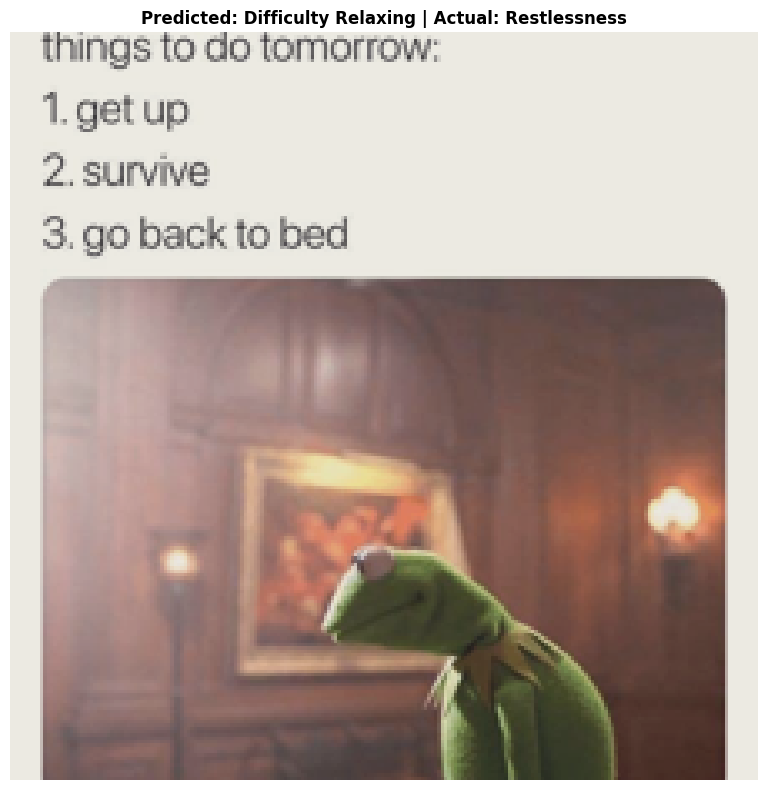


Example 2 (ID: TE-26):
  Predicted: Difficulty Relaxing (confidence: 1.0000)
  Actual: Restlessness
  OCR Text: Me staring at the wall for 20 mins instead of getting ready in the morning
  Figurative Reasoning: 1. Cause-Effect: The meme shows a woman lying in bed, looking at the wall, and waiting for 20 minutes. This could be a representation of the feeling of waiting for something or someone, possibly a significant other, to arrive. The woman might be feeling impatient or anxious, as she is lying in bed, which is often associated with relaxation and rest. 2. Figurative Understanding: The image of the woman looking at the wall could symbolize the feeling of being stuck or trapped in a situation, with no immediate solution or escape. The 20-minute waiting time might represent the duration of the woman's impatience or the time it takes for her to find a way out of her current predicament. 3. Mental State: The woman in the meme is likely experiencing a mix of emotions, such as impatience

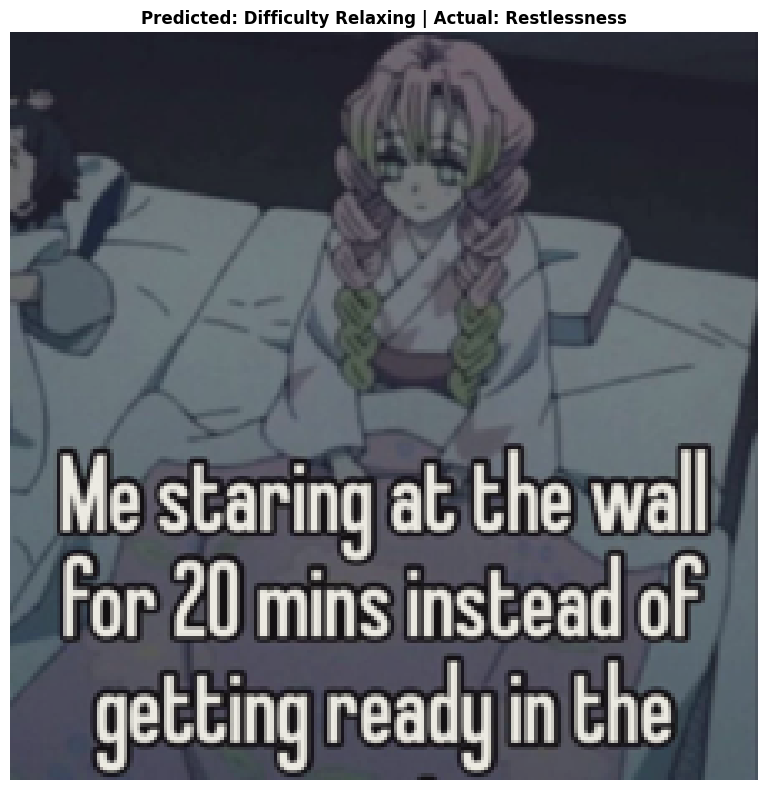


Example 3 (ID: TE-136):
  Predicted: Impending Doom (confidence: 0.9999)
  Actual: Restlessness
  OCR Text: I don't know how many Whatever happens, happens" is left in me
  Figurative Reasoning: 1. Cause-Effect: The meme is about a man who is concerned about how many "what ever happens" situations are left in him. This suggests that the man is experiencing a sense of uncertainty or anxiety about the future and the potential events that may occur. 2. Figurative Understanding: The phrase "what ever happens" can be interpreted as a metaphor for unexpected or unfavorable events. The man's concern about the number of such situations left in him can be seen as a representation of his vulnerability to life's uncertainties and the potential for negative outcomes. 3. Mental State: The man appears to be in a state of worry or unease, as he is contemplating the number of "what ever happens" situations left in him. This could indicate that he is experiencing anxiety or stress related to the futur

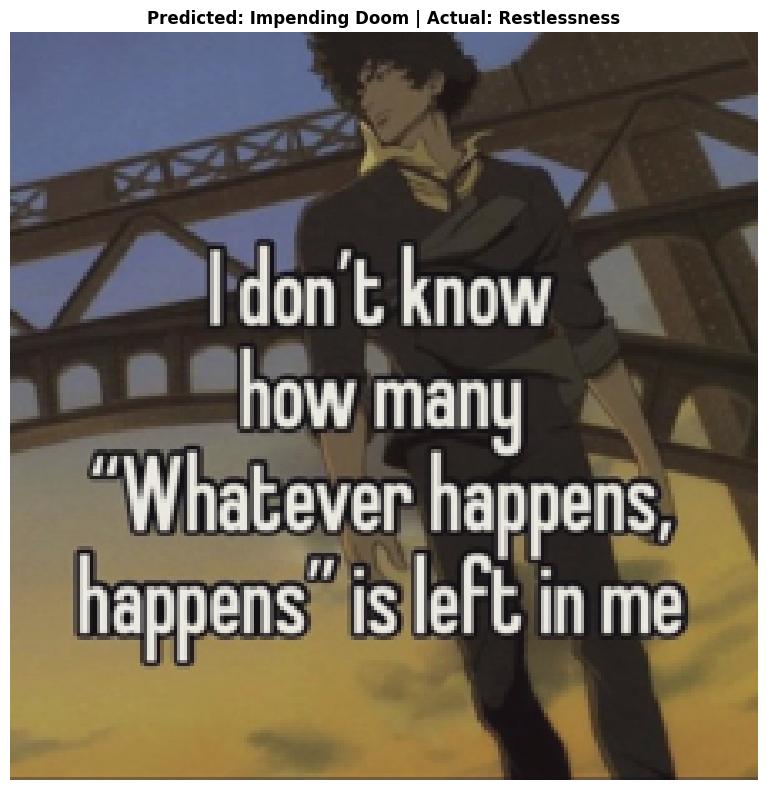


--- Misclassified examples for Excessive Worry (actual class) ---

Example 1 (ID: TE-49):
  Predicted: Restlessness (confidence: 1.0000)
  Actual: Excessive Worry
  OCR Text: me trying to calm myself and pretending everything is fine. N
  Figurative Reasoning: 1. Cause-Effect: The meme shows a cartoon character, possibly Spongebob, sitting on the ground with a bottle next to him. The cause of this situation could be that the character is feeling overwhelmed or stressed, possibly due to a difficult task or situation. The effect of this could be that the character is trying to find a way to cope with the stress or task at hand. 2. Figurative Understanding: The meme might be using the image of a cartoon character to represent a common feeling of being overwhelmed or stressed. The character's facial expression and body language could be interpreted as a metaphor for the emotions that people experience when they feel overwhelmed or stressed. 3. Mental State: The meme shows a character that

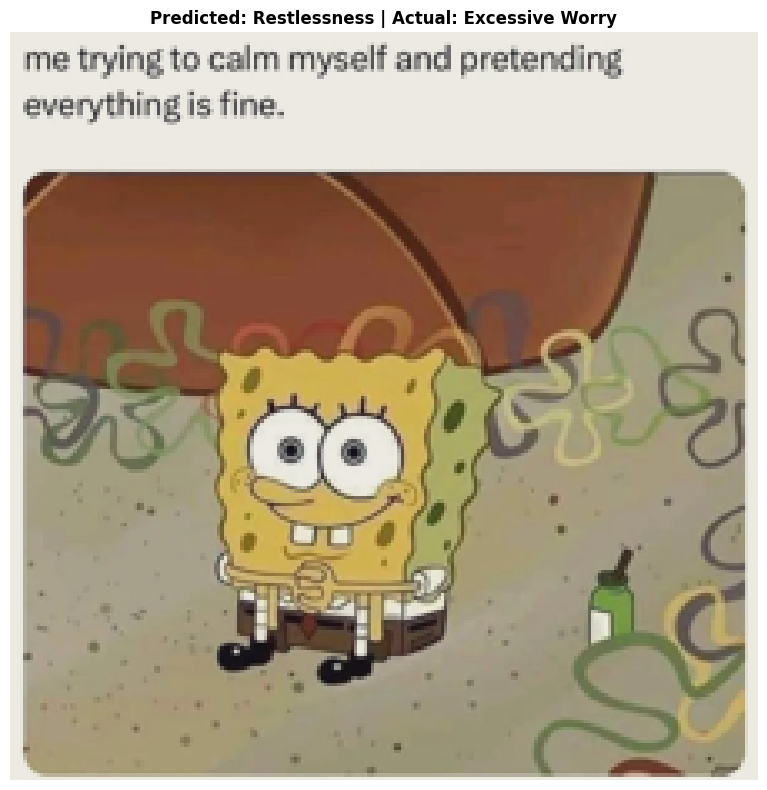


Example 2 (ID: TE-495):
  Predicted: Lack of Worry Control (confidence: 0.9999)
  Actual: Excessive Worry
  OCR Text: (C.) My anxieties have anxieties.
  Figurative Reasoning: 1. Cause-Effect: The meme shows two cartoon characters, Charlie Brown and Snoopy, sitting on a bench with their mouths open, appearing anxious or worried. This could be a representation of the stress or anxiety that people experience in their daily lives. 2. Figurative Understanding: The meme might be suggesting that people often feel anxious or worried, just like the characters in the cartoon. It could also be a commentary on the common human experience of feeling overwhelmed or stressed in certain situations. 3. Mental State: The meme portrays the two cartoon characters as anxious or worried, which could be a reflection of their emotional state in the image. This could be a representation of the mental state of people who experience anxiety or stress in their lives.


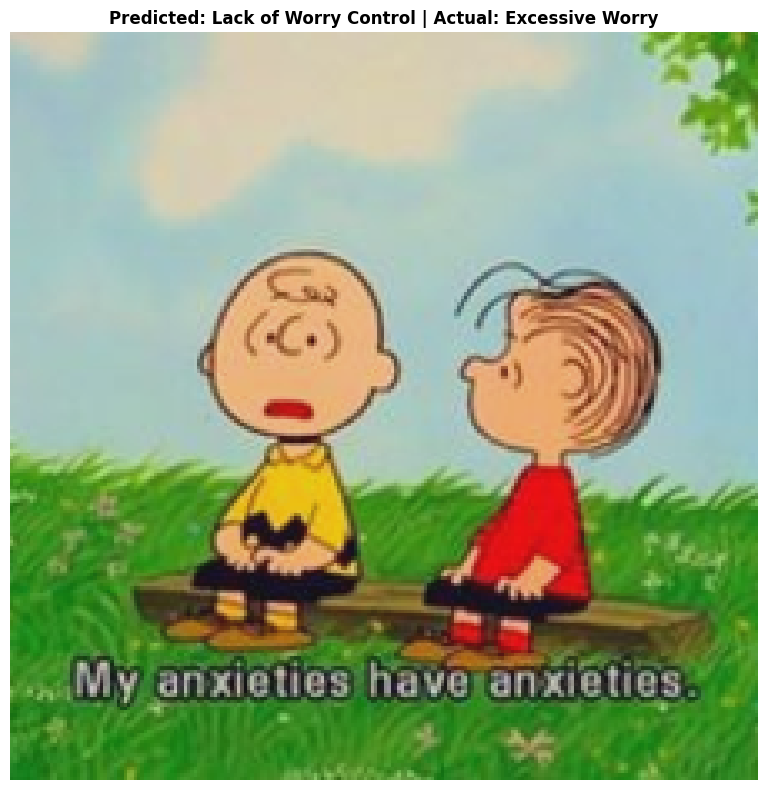


Example 3 (ID: TE-405):
  Predicted: Lack of Worry Control (confidence: 0.9999)
  Actual: Excessive Worry
  OCR Text: Me talking to my depression, anxiety, ed and inner demons before I go out with friends for the night We're all gonna have FUN!
  Figurative Reasoning: 1. Cause-Effect: The meme shows a woman with a funny facial expression, suggesting that she is experiencing a negative emotion or mental state. The cause of this emotional state could be related to her depression, anxiety, or stress. 2. Figurative Understanding: The meme might be using humor to convey a deeper message about mental health or emotional well-being. It could be suggesting that people with depression or other mental health issues should not be judged or stigmatized, and that they should seek help and support from friends, family, or professionals. 3. Mental State: The woman in the meme appears to be in a state of distress, sadness, or frustration. This emotional state could be related to her depression, anxie

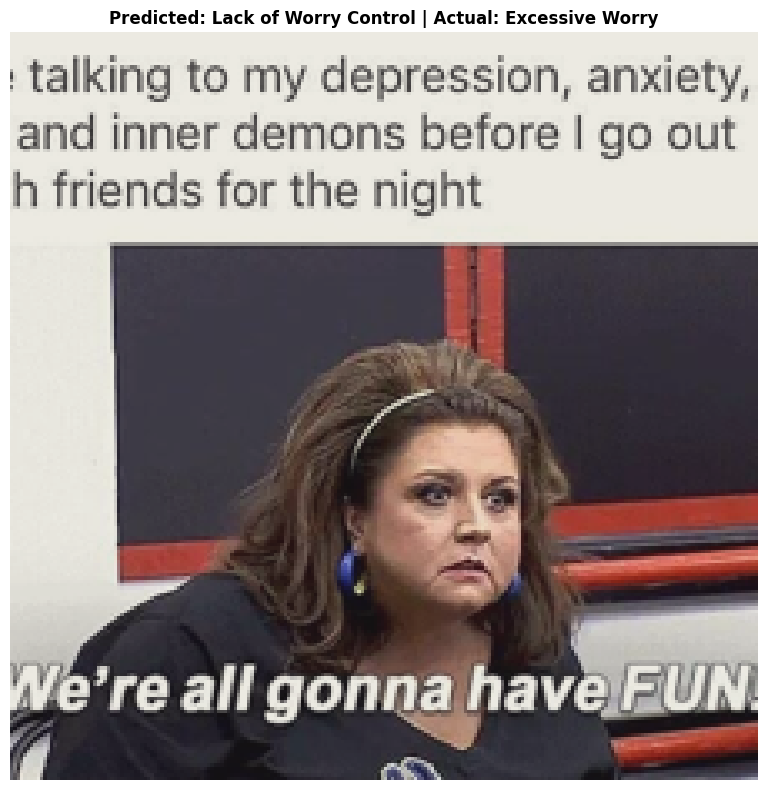


--- Misclassified examples for Nervousness (actual class) ---

Example 1 (ID: TE-230):
  Predicted: Difficulty Relaxing (confidence: 1.0000)
  Actual: Nervousness
  OCR Text: me at 1am setting my 6am alarm
  Figurative Reasoning: 1. Cause-Effect: The meme shows a stuffed animal, specifically a stuffed elephant, sitting in a bathtub. This could be interpreted as a symbolic representation of depression or loneliness. The cause of this situation could be a lack of social interaction or emotional support, leading to feelings of isolation and sadness. 2. Figurative Understanding: The stuffed animal in the bathtub represents a person struggling with depression or loneliness. The bathtub symbolizes a place of solitude, where the person might seek comfort or escape from their emotional state. The stuffed animal could also represent a childhood memory or a connection to a loved one, further emphasizing the emotional depth of the meme. 3. Mental State: The meme portrays a person experiencing fe

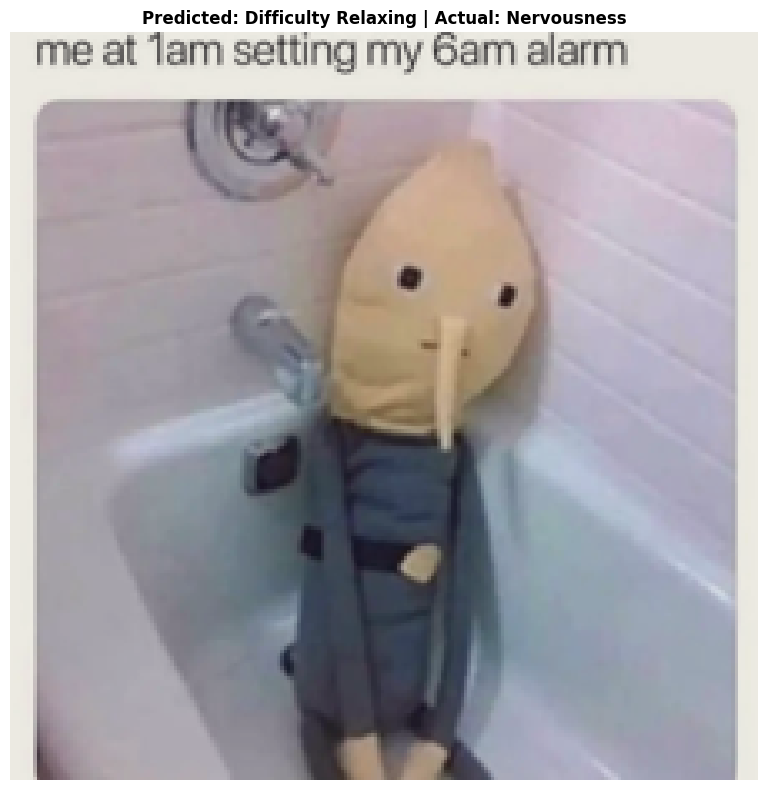


Example 2 (ID: TE-203):
  Predicted: Restlessness (confidence: 1.0000)
  Actual: Nervousness
  OCR Text: Be awkward by being quiet Be awkward by talking fh/dailylaughterdose
  Figurative Reasoning: 1. Cause-Effect: The person is contemplating which path to take, possibly due to indecision or uncertainty about the direction they should go. 2. Figurative Understanding: The image can be interpreted as a metaphor for life choices and decisions, with the person at the fork representing the individual making choices in their life. The dark, stormy environment can symbolize challenges or obstacles that the person may face in their journey. 3. Mental State: The person appears to be in a contemplative state, as they are standing at the fork and considering their options.


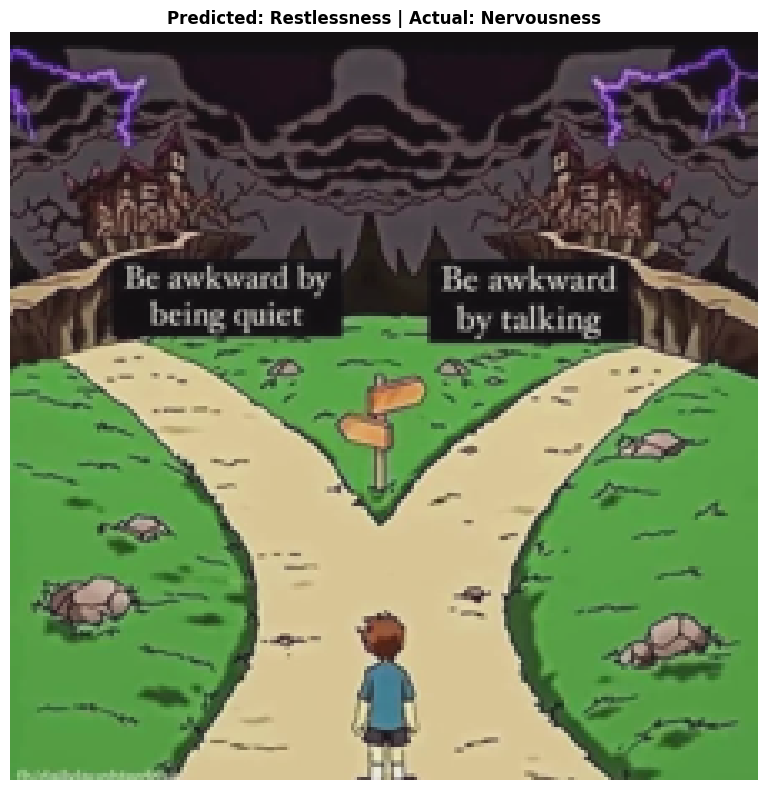


Example 3 (ID: TE-213):
  Predicted: Excessive Worry (confidence: 0.9999)
  Actual: Nervousness
  OCR Text: Noticing the slightest change in text messages with anyone & wondering if u did something wrong I'm sensitive, you know. B
  Figurative Reasoning: 1. Cause-Effect: The meme shows a cartoon character, possibly a character from the movie "The Powerpuff Girls," with a sad expression and a caption that says "I'm Sensitive." The cause of the character's sadness could be related to the character's emotional state or the situation it is in. 2. Figurative Understanding: The character's sadness might be interpreted as a metaphor for being sensitive to the feelings and emotions of others. The character's sadness could also be seen as a representation of vulnerability or being easily hurt by others' words or actions. 3. Mental State: The character appears to be in a state of sadness or emotional distress, as indicated by its facial expression and the caption. The character might be feeling

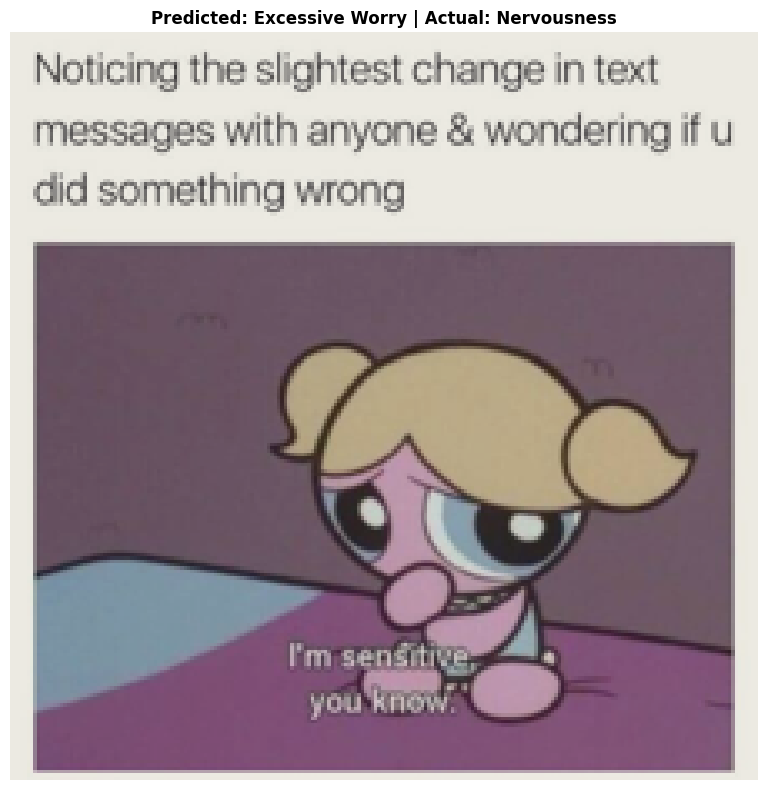


--- Misclassified examples for Difficulty Relaxing (actual class) ---

Example 1 (ID: TE-349):
  Predicted: Nervousness (confidence: 0.9999)
  Actual: Difficulty Relaxing
  OCR Text: Your friends when you, a socially awkward & anxious person, flirt with someone for the first time What's he doing? He's beginning to believe. But it was all a dream...
  Figurative Reasoning: 1. Cause-Effect: The man's facial expressions in the panels suggest that he is experiencing a range of emotions, from happiness to distress. 2. Figurative Understanding: The different expressions on the man's face can be interpreted as a representation of the ups and downs of life, or the different stages of emotions that a person may experience. 3. Mental State: The man's facial expressions indicate that he is experiencing a mix of positive and negative emotions, which could be a reflection of his mental state or the challenges he is facing in his life.


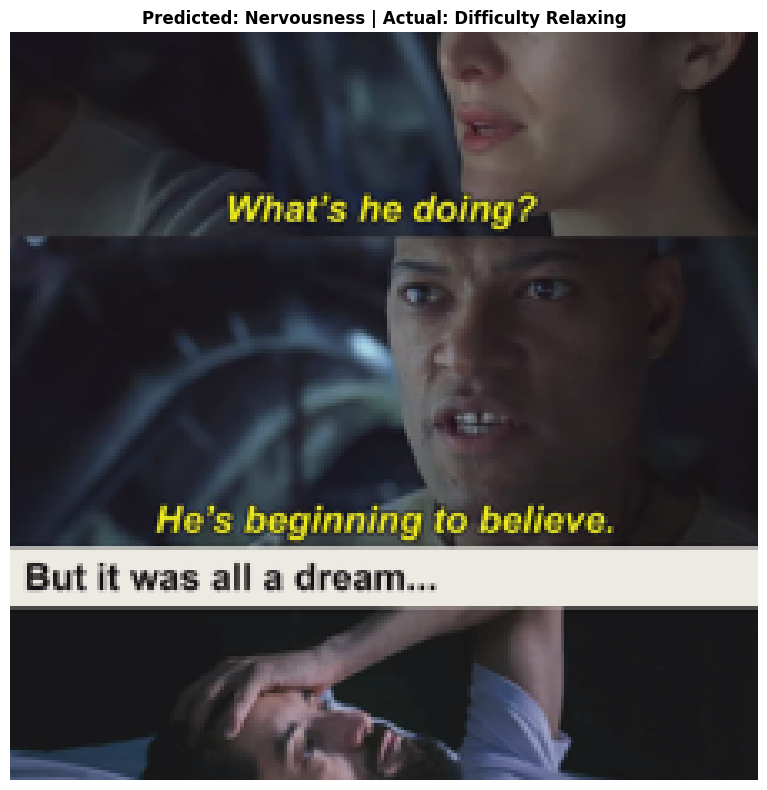


Example 2 (ID: TE-596):
  Predicted: Restlessness (confidence: 0.9999)
  Actual: Difficulty Relaxing
  OCR Text: wwwwwwHAVING A PANIC ATTACK BUT NOT BEING ABLE TO SHOW IT BECAUSE YOU ARE IN THE MIDDLE OF WORK BE LIKE imgflip.com
  Figurative Reasoning: 1. Cause-Effect: The skeleton is sitting on a bench, which could be a representation of the consequences of not taking care of one's mental health. It might symbolize the negative impact of stress, anxiety, or depression on a person's well-being. 2. Figurative Understanding: The skeleton sitting on the bench represents the concept of mental health and the importance of taking care of it. The image can be interpreted as a reminder to prioritize mental health and seek help when needed, as it is a crucial aspect of overall well-being. 3. Mental State: The skeleton sitting on the bench represents a state of inactivity or lack of engagement in life. It could symbolize feelings of hopelessness, apathy, or disconnection from one's surroundings

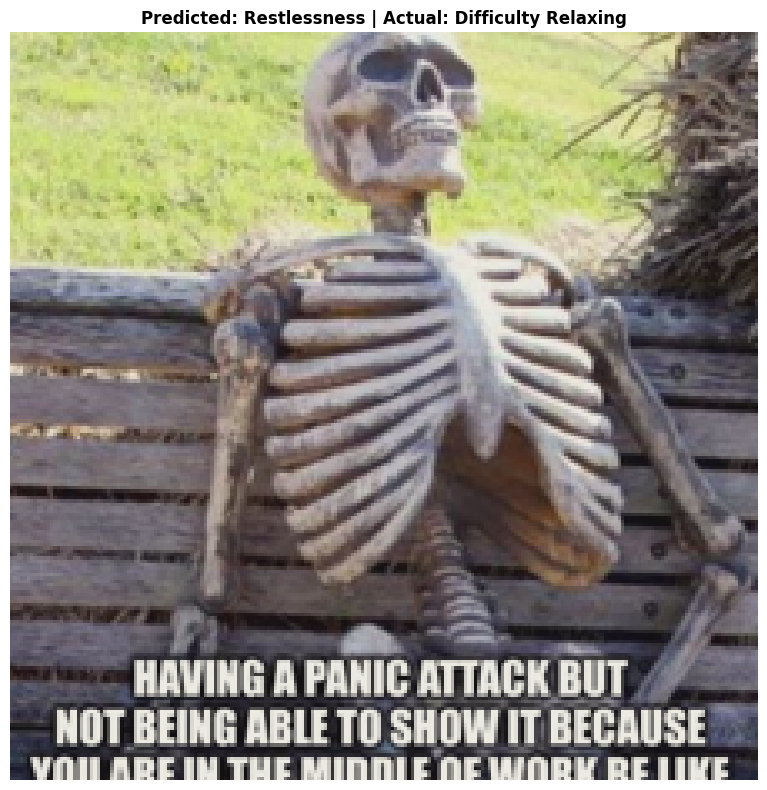


Example 3 (ID: TE-471):
  Predicted: Lack of Worry Control (confidence: 0.9998)
  Actual: Difficulty Relaxing
  OCR Text: Having a panic attack and someone says "Can you not just relax?" Have you ever tried to relax? It is a paradox.
  Figurative Reasoning: 1. Cause-Effect: The man in the meme is experiencing stress and anxiety, possibly due to work or personal issues. He is trying to relax by swinging a golf club, which is an unconventional way to relieve stress. 2. Figurative Understanding: The meme can be interpreted as a metaphor for dealing with stress and anxiety in an unconventional manner. The man's actions of swinging a golf club in a non-golfing context symbolize finding creative ways to cope with challenging situations. 3. Mental State: The man in the meme is experiencing a state of stress, anxiety, and frustration. He is trying to find a way to relax and cope with his emotions, which is evident from his actions of swinging the golf club.


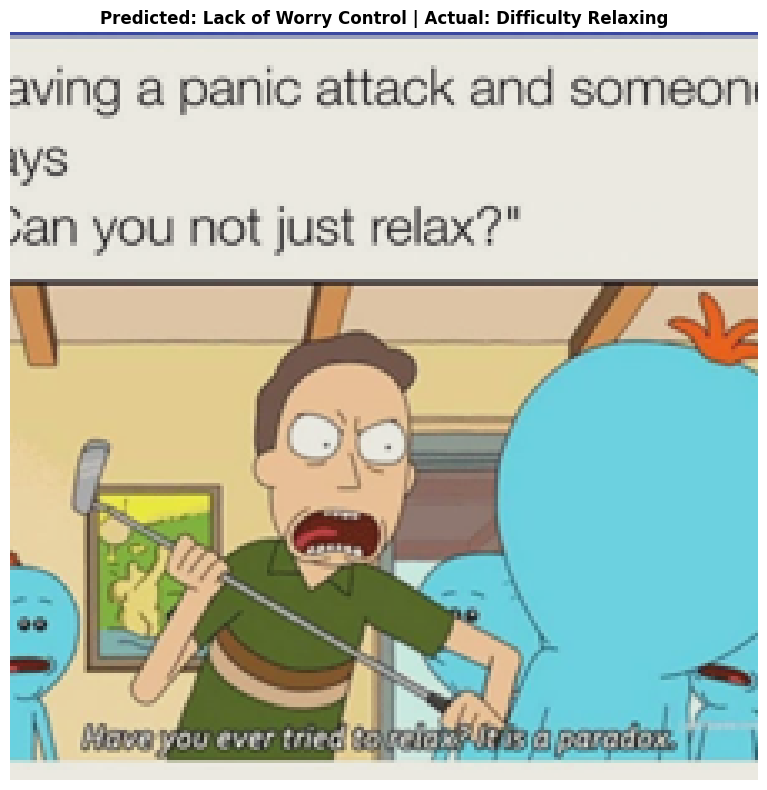

Test Loss: 2.2461
Test Macro-F1: 0.6851, Weighted-F1: 0.6848


(0.6851071306175776, 0.6847534120670663)

In [ ]:
inference_misclassified(test_data, "multimodal_anxiety.pth")